In [1]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

In [2]:
from configs import task_dataframe

In [3]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy

In [4]:
df = pd.read_pickle(f'{root_dir}/results/results.pkl')

In [16]:
df.columns

Index(['clip_correct', 'obj', 'detail', 'overall', 'valid_count', '_runtime',
       '_timestamp', 'clip_similarity_overall', '_step', '_wandb', 'visual',
       'textual', 'seed', 'shot', 'model', 'stage', 'ft_mode', 'task_id',
       'x_space', 'data_mode', 'eval_mllm', 'file_type', 'finetuned',
       'task_type', 'prompt_type', 'theta_space', 'eval_task_theme',
       'run_name', 'run_id'],
      dtype='object')

In [22]:
def get_acc(
    model, 
    mode, 
    shot, 
    task_id, 
    metric, 
    prompt_type, 
    data_mode,
    eval_model,
):
    run_df = df[
        (df['model'] == model) &
        (df['file_type'] == mode) &
        (df['shot'] == shot) &
        (df['task_id'] == task_id) &
        (df['prompt_type'] == prompt_type) & 
        (df['data_mode'] == data_mode)  
    ]

    if eval_model == 'clip':
        run_df = run_df[run_df['eval_mllm'] == 'llava']
        if metric in ['correct', 'overall']:
            metric = 'clip_correct'
    else:
        run_df = run_df[run_df['eval_mllm'] == eval_model]
    
    if len(run_df):
        # check whether it is nan or not
        if metric == 'correct':
            if not 'correct' in run_df.columns:
                # in old experiments, the column is named as "overall" instead of "correct"
                metric = 'overall'
        if np.isnan(float(run_df[metric].iloc[0])):
            print(run_df[metric])
            return run_df
        else:
            return float(run_df[metric].iloc[0])     
    else:
        return 0

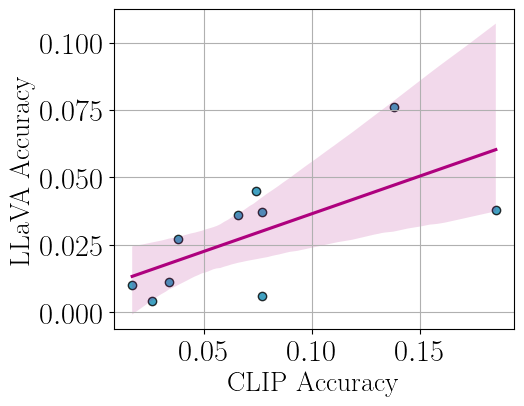

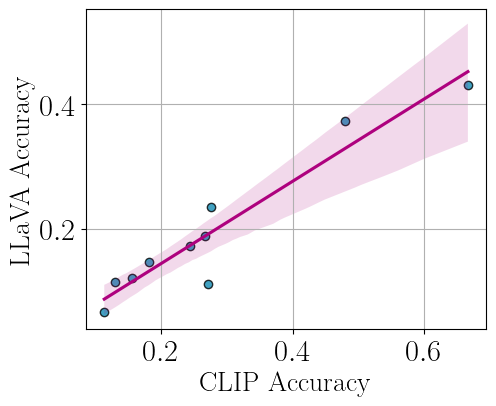

In [6]:
for mode in ['text', 'image']:
    acc_dict = {'clip': [], 'llava': []}
    for task_id in range(1, 11):
        acc = get_acc(
            model = 'seed', 
            mode = mode, 
            shot = 2, 
            task_id = task_id, 
            metric = 'clip_correct', 
            prompt_type = 'default',
            data_mode = 'default',
        )
        acc_dict['clip'].append(acc)
        
        acc = get_acc(
            model = 'seed', 
            mode = mode, 
            shot = 2, 
            task_id = task_id, 
            metric = 'correct', 
            prompt_type = 'default',
            data_mode = 'default',
        )
        acc_dict['llava'].append(acc)
            
    acc_df = pd.DataFrame(acc_dict)

    # Plot with a regression line and confidence interval
    plt.rc('font', family='serif', serif='times new roman')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=22)
    plt.rc('ytick', labelsize=22)
    mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

    lw = 2.5
    markers = ['s', 'o']
    colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
    models = ['Emu', 'SEED-LLaMA', 'GILL']
    lts = ['--', '-']
    marker_sizes = [6, 5]
    shots = [1,2,4]

    fig, ax = plt.subplots(nrows = 1, ncols = 1, sharey = True)
    fig.subplots_adjust(left=0.18, bottom=.18, right=0.98, top=.98, wspace=0.05, hspace = 0.3) #margin of the figure
    fig.set_size_inches(5, 4) #exact size of the figure
    sns.regplot(x=acc_df['clip'], y=acc_df['llava'], ci=95, color=colors[0], line_kws={'color': colors[5]}, scatter_kws={'color': colors[3], 'edgecolor': 'k'})

    # plt.title('Correlation between CLIP-Similarity and LLaVA-Accuracy with Regression Line')
    plt.xlabel('CLIP Accuracy', fontsize = 20)
    plt.ylabel('LLaVA Accuracy', fontsize = 20)
    plt.grid(True)
    fig.savefig(f'{root_dir}/figures/clip_llava_{mode}.pdf')
    plt.show()
            

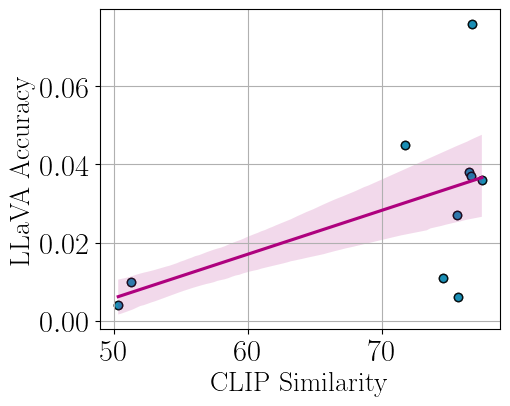

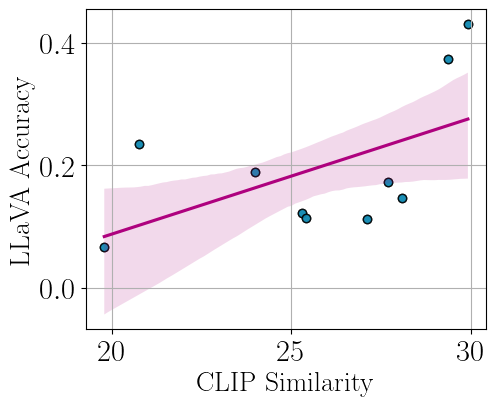

In [7]:
for mode in ['text', 'image']:
    acc_dict = {'clip': [], 'llava': []}
    for task_id in range(1, 11):
        for misleading in [0,1]:
            acc = get_acc(
                model = 'seed', 
                mode = mode, 
                shot = 2, 
                task_id = task_id, 
                metric = 'clip_similarity_overall', 
                prompt_type = 'default',
                data_mode = 'default',
            )
            acc_dict['clip'].append(acc)
            
            acc = get_acc(
                model = 'seed', 
                mode = mode, 
                shot = 2, 
                task_id = task_id, 
                metric = 'correct', 
                prompt_type = 'default',
                data_mode = 'default',
            )
            acc_dict['llava'].append(acc)
            
    acc_df = pd.DataFrame(acc_dict)

    # Plot with a regression line and confidence interval
    plt.rc('font', family='serif', serif='times new roman')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=22)
    plt.rc('ytick', labelsize=22)
    mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

    lw = 2.5
    markers = ['s', 'o']
    colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
    models = ['Emu', 'SEED-LLaMA', 'GILL']
    lts = ['--', '-']
    marker_sizes = [6, 5]
    shots = [1,2,4]

    fig, ax = plt.subplots(nrows = 1, ncols = 1, sharey = True)
    fig.subplots_adjust(left=0.18, bottom=.18, right=0.98, top=.98, wspace=0.05, hspace = 0.3) #margin of the figure
    fig.set_size_inches(5, 4) #exact size of the figure
    sns.regplot(x=acc_df['clip'], y=acc_df['llava'], ci=95, color=colors[0], line_kws={'color': colors[5]}, scatter_kws={'color': colors[3], 'edgecolor': 'k'})

    # plt.title('Correlation between CLIP-Similarity and LLaVA-Accuracy with Regression Line')
    plt.xlabel('CLIP Similarity', fontsize = 20)
    plt.ylabel('LLaVA Accuracy', fontsize = 20)
    plt.grid(True)
    fig.savefig(f'{root_dir}/figures/clip_similarity_llava_{mode}.pdf')
    plt.show()
            

# Compare with Human Evaluation

In [8]:
# get human evaluation
labels = {}
human_labels = []
results_folder = f'{root_dir}/results/exps/seed_image/shot_2/default'
for task_id in range(1, 11):
    task_folder = f'{results_folder}/task_{task_id}'
    files = os.listdir(task_folder)
    for file in files:
        if file[1] == '_' and file.endswith('.json'):
            with open(f'{task_folder}/{file}', 'r') as f:
                data = json.load(f)
                human_labels.append((task_id, int(file[0]), data['human_eval']))
labels['human'] = pd.DataFrame(sorted(human_labels, key = lambda x: x[0]*10 + x[1]), columns = ['task_id', 'sample_id', 'label'])                

In [9]:
# get mllm evaluation

def get_mllm_eval(mllm, num=10):
    mllm_labels = []
    for task_id in range(1, 11):
        eval_folder = 'llava_eval' if mllm == 'clip' else f'{mllm}_eval'
        results_csv = pd.read_csv(f"{root_dir}/results/evals/seed_image/{eval_folder}/shot_2/default/task_{task_id}_summary.csv")
        col = 'clip_correct' if mllm == 'clip' else 'correct'
        pred_labels = results_csv[col][:num]
        for i, label in enumerate(pred_labels):
            mllm_labels.append((task_id, i, int(label == 'True')))
            
    return pd.DataFrame(mllm_labels, columns = ['task_id', 'sample_id', 'label'])
            

In [10]:
for mllm in ['llava', 'gemini', 'qwen', 'clip']:
    labels[mllm] = get_mllm_eval(mllm)
    
accs = {}
for estimator in ['human', 'llava', 'gemini', 'qwen', 'clip']:
    accs[estimator] = labels[estimator]['label'].mean()

In [11]:
# compute the p value that the human and mllm are different
for mllm in ['llava', 'gemini', 'qwen', 'clip']:
    acc = sum(labels['human']['label'] == labels[mllm]['label'])/100
    p_value = scipy.stats.binom_test(sum(labels['human']['label'] == labels[mllm]['label']), n=100, p=accs['human'])
    print(f"Human vs {mllm}: {acc:.2f} (p-value: {p_value:.2f})")

Human vs llava: 0.89 (p-value: 0.00)
Human vs gemini: 0.92 (p-value: 0.00)
Human vs qwen: 0.78 (p-value: 0.00)
Human vs clip: 0.85 (p-value: 0.00)


/tmp/ipykernel_2676203/769118847.py:4: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = scipy.stats.binom_test(sum(labels['human']['label'] == labels[mllm]['label']), n=100, p=accs['human'])


In [12]:
for mllm in ['llava', 'gemini', 'qwen', 'clip']:
    labels[mllm] = get_mllm_eval(mllm, num=1000)
    
accs = {}
for estimator in ['llava', 'gemini', 'qwen', 'clip']:
    accs[estimator] = labels[estimator]['label'].mean()

# compute the p value that the human and mllm are different
for mllm in ['llava', 'qwen', 'clip']:
    acc = (labels['gemini']['label'] == labels[mllm]['label']).mean()
    p_value = scipy.stats.binom_test(acc*1000, n=1000, p=accs['gemini'])
    print(f"Gemini vs {mllm}: {acc:.2f} (p-value: {p_value:.2f})")

Gemini vs llava: 0.88 (p-value: 0.00)
Gemini vs qwen: 0.82 (p-value: 0.00)
Gemini vs clip: 0.84 (p-value: 0.00)


/tmp/ipykernel_2676203/2126567886.py:11: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = scipy.stats.binom_test(acc*1000, n=1000, p=accs['gemini'])


In [13]:
acc

0.8414

# Compare with Gemini Accuracy

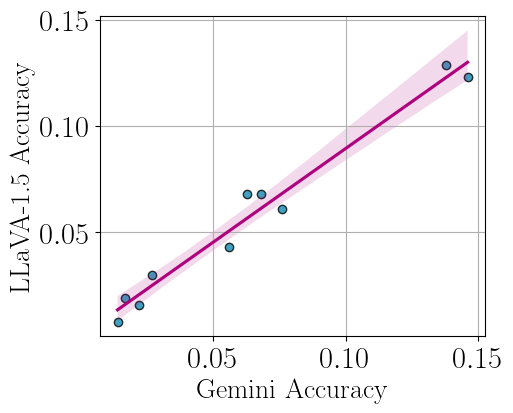

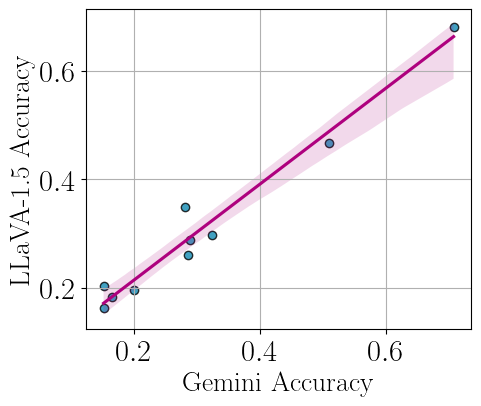

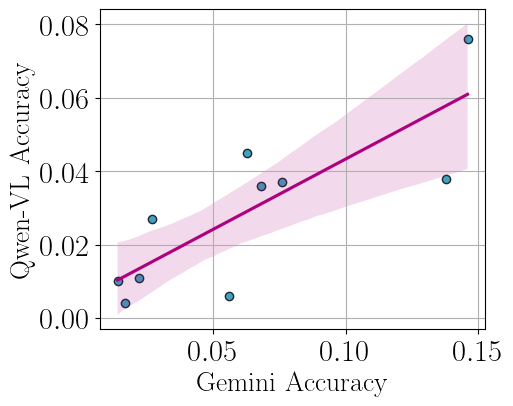

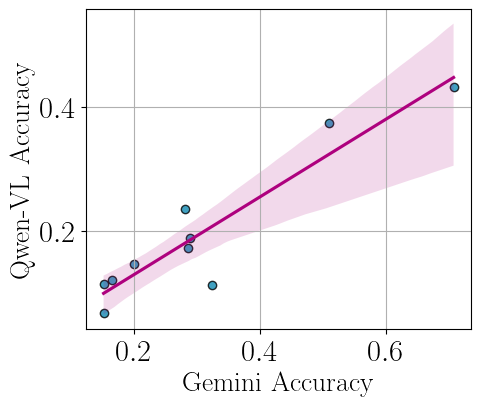

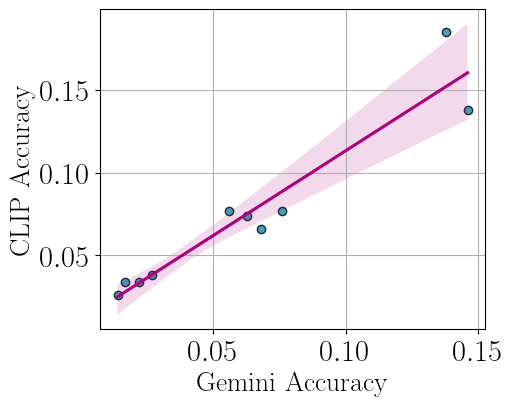

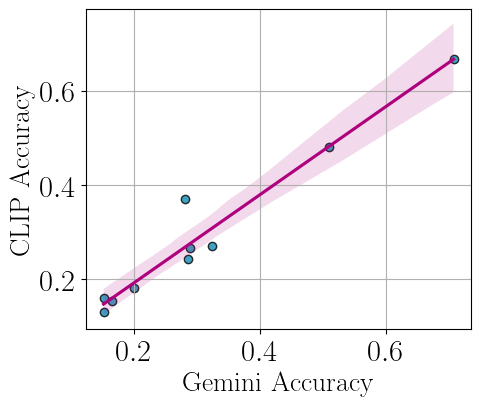

In [27]:
label_converter = {
    'llava': 'LLaVA-1.5',
    'gemini': 'Gemini',
    'qwen': 'Qwen-VL',
    'clip': 'CLIP',
}

for model in ['llava', 'qwen', 'clip']:
    for mode in ['text', 'image']:
        acc_dict = {'gemini': [], model: []}
        for task_id in range(1, 11):
            acc = get_acc(
                model = 'seed', 
                mode = mode, 
                shot = 2, 
                task_id = task_id, 
                metric = 'correct', 
                prompt_type = 'default',
                data_mode = 'default',
                eval_model = 'gemini',
            )
            acc_dict['gemini'].append(acc)
            
            acc = get_acc(
                model = 'seed', 
                mode = mode, 
                shot = 2, 
                task_id = task_id, 
                metric = 'correct', 
                prompt_type = 'default',
                data_mode = 'default',
                eval_model = model,
            )
            acc_dict[model].append(acc)
                
        acc_df = pd.DataFrame(acc_dict)

        # Plot with a regression line and confidence interval
        plt.rc('font', family='serif', serif='times new roman')
        plt.rc('text', usetex=True)
        plt.rc('xtick', labelsize=22)
        plt.rc('ytick', labelsize=22)
        mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

        lw = 2.5
        markers = ['s', 'o']
        colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
        lts = ['--', '-']
        marker_sizes = [6, 5]
        shots = [1,2,4]

        fig, ax = plt.subplots(nrows = 1, ncols = 1, sharey = True)
        fig.subplots_adjust(left=0.18, bottom=.18, right=0.95, top=.98, wspace=0.05, hspace = 0.3) #margin of the figure
        fig.set_size_inches(5, 4) #exact size of the figure
        sns.regplot(x=acc_df['gemini'], y=acc_df[model], ci=95, color=colors[0], line_kws={'color': colors[5]}, scatter_kws={'color': colors[3], 'edgecolor': 'k'})

        # plt.title('Correlation between CLIP-Similarity and LLaVA-Accuracy with Regression Line')
        plt.xlabel('Gemini Accuracy', fontsize = 20)
        plt.ylabel(f'{label_converter[model]} Accuracy', fontsize = 20)
        plt.grid(True)
        fig.savefig(f'{root_dir}/figures/gemini_similarity_{model}_{mode}.pdf')
        plt.show()
                